In [33]:
import transformers
import torch
import numpy as np

In [3]:
!pip install datasets

In [65]:
from datasets import load_dataset
emotions = load_dataset("emotion", trust_remote_code=True)
labels=emotions['train'].features['label']
id2label={k:v for k,v in enumerate(labels.names)}
id2label

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [5]:
from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained("distilbert-base-cased")

def tokenize(batch):
 return tokenizer(batch["text"], padding=True, truncation=True)

emotions_encoded= emotions.map(tokenize,batched=True, batch_size=None)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
# Load the model
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device) # AutoModel.from_pretrained class loads the weights of pretrained models

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

## Extracting Last Hidden state

The "last hidden state" in the context of transformer models like BERT refers to the final layer's hidden representations for each token in the input sequence after the model has processed it. Here's a detailed explanation:

### Understanding Hidden States

#### Hidden States in Transformer Models:

- Transformer models consist of multiple layers of self-attention and feed-forward neural networks.
- Each layer produces a hidden state for every token in the input sequence. These hidden states are vectors that capture various aspects of the token's context within the sequence.

#### Layer Structure:

- A typical transformer model, such as BERT, has several layers (e.g., 12 layers for BERT-base, 24 layers for BERT-large).
- Each layer processes the hidden states from the previous layer and outputs a new set of hidden states.

### Last Hidden State

#### Final Layer Output:
- The last hidden state refers to the hidden representations produced by the final layer of the model.

#### Token Representation:
- For each token in the input sequence, there is a corresponding hidden state in the last layer. These hidden states are vectors of a fixed size (e.g., 768 dimensions for BERT-base).

#### Contextual Information:
- These hidden states capture rich contextual information about the tokens, informed by all the preceding layers' computations and the entire input sequence.

### Practical Use of Last Hidden State

The last hidden state is often used for various downstream tasks because it contains the most refined and contextually aware representations of the input tokens. For example:

#### Classification:

- **[CLS] Token**: For classification tasks, the hidden state corresponding to the special [CLS] token is used. This token is added to the beginning of the input sequence, and its hidden state in the last layer is designed to capture the overall meaning of the sequence.
- **Usage**: This [CLS] hidden state is fed into a classification layer (usually a simple feed-forward neural network) to perform the classification.

#### Token-Level Tasks:

- **NER, POS Tagging**: For tasks like Named Entity Recognition (NER) or Part-of-Speech (POS) tagging, the hidden states of all tokens in the last layer are used to make predictions for each token.

### Shape of Last Hidden State

#### Shape Explanation:
- The shape of `last_hidden_state` will be (batch_size, sequence_length, hidden_size).
  - **batch_size**: Number of input sequences processed together (useful for batch processing).
  - **sequence_length**: Number of tokens in the input sequence (including special tokens like [CLS] and [SEP]).
  - **hidden_size**: Dimensionality of the hidden state vectors (e.g., 768 for BERT-base).


The last hidden state in transformer models like BERT is a crucial component that provides the final, contextually rich representations of the input tokens. These representations are used for various downstream tasks, making them an essential part of how these models achieve high performance on a wide range of NLP tasks.


In [7]:
# Example
text= "this is a test"
inputs = tokenizer(text,return_tensors='pt')
#place inputs dictionary to the same deveice
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs=model(inputs["input_ids"], inputs["attention_mask"])
last_hid_state=outputs.last_hidden_state

In [8]:
""" For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token
appears at the start of each sequence, we can extract it by simply indexing into
outputs.last_hidden_state"""
# hidden state corresponding to all input tokens/input sequence.
# token arragement is like: [CLS] sequence1_tokens [SEP] sequence2_tokens [SEP] ......
last_hid_state.shape

torch.Size([1, 6, 768])

In [9]:
# hidden state corresponding to [CLS] token
cls_hid_state=last_hid_state[:,0,:]
cls_hid_state.shape

torch.Size([1, 768])

For the whole dataset by create a new hidden_state column that stores all these vectors.

In [10]:
def extract_CLS_hidden_states(batch):
    # Place the model inputs on GPU

    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names }
    # Extracting the last hidden state
    with torch.no_grad():
        outputs=model(**inputs)
    last_hidden_state = outputs.last_hidden_state
    # return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0,:].cpu().numpy()}

In [11]:
# extracting [CLS] hidden states of our emotions dataset
emotions_encoded.set_format("torch",columns=["input_ids","attention_mask","label"])
emotions_CLS_hidden_state = emotions_encoded.map(extract_CLS_hidden_states, batched=True, batch_size=8,)
emotions_CLS_hidden_state

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [16]:
# emotions_CLS_hidden_state.save_to_disk(os.path.join(r"/content/drive/MyDrive/model_params","emotions_CLS_hidden_state.pt"))

Saving the dataset (0/1 shards):   0%|          | 0/16000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

## Creating a Feature Matrix

In [4]:
from datasets import load_from_disk
emotions_CLS_hidden_state = load_from_disk(r'data/emotions_CLS_hidden_state')

In [5]:
# Hidden states as input features
# Labels as targets
X_train = emotions_CLS_hidden_state["train"]["hidden_state"]
y_train = emotions_CLS_hidden_state["train"]["label"]

X_valid = emotions_CLS_hidden_state["validation"]["hidden_state"]
y_valid = emotions_CLS_hidden_state["validation"]["label"]

X_test = emotions_CLS_hidden_state["test"]["hidden_state"]
y_test = emotions_CLS_hidden_state["test"]["label"]

### Training a simple classifier

In [15]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [41]:
lr_clf.score(X_valid, y_valid)

0.4365

In [105]:
# classification report
from sklearn.metrics import classification_report

y_pred=lr_clf.predict(X_valid)
pd.set_option('display.precision', 2)
clf_report=pd.DataFrame(classification_report(y_valid, y_pred,output_dict=True,labels=list(id2label.keys()),target_names=list(id2label.values())),).T
clf_report

,precision,recall,f1-score,support
sadness,0.40,0.53,0.45,550.00
joy,0.47,0.65,0.55,704.00
love,0.33,0.07,0.12,178.00
anger,0.46,0.23,0.30,275.00
fear,0.42,0.20,0.27,212.00
surprise,0.50,0.02,0.05,81.00
accuracy,0.44,0.44,0.44,0.44
macro avg,0.43,0.29,0.29,2000.00
weighted avg,0.43,0.44,0.40,2000.00


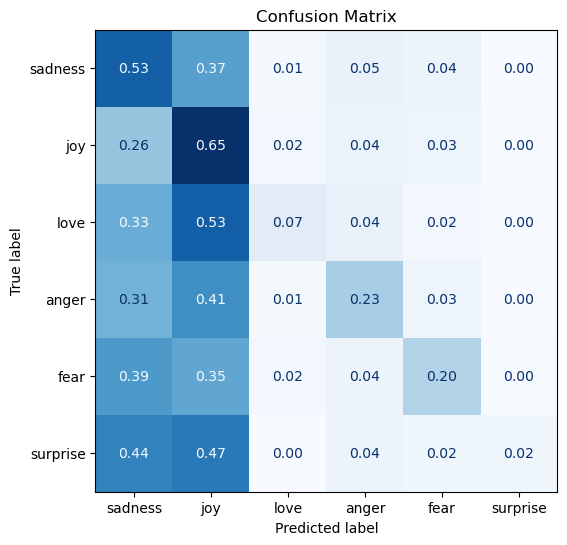

In [160]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_true, y_predictions, labels ):
    cm = confusion_matrix(y_valid, y_pred,labels=labels,normalize='true')
    
    fig, ax = plt.subplots(figsize=(6,6))
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id2label.values()))
    cm_disp.plot(cmap='Blues',colorbar=False,values_format='.2f',ax=ax)
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(y_valid, y_pred, labels=list(id2label.keys()))